# Regular Genomics Project **RNA Localisation**


---

**Problem definition**:

TODO


### **1.** Data Preparation

Firstly, we import several necessary packages and load in our data:

In [5]:
import pandas as pd
import numpy as np
from notes.utils import read_model_file
from notes.visualization import plot_line_graph, scatter_plot, box_plot
from sklearn.model_selection import KFold, train_test_split
from keras.callbacks import EarlyStopping
import datetime

In [6]:
# Initializing test/train split


colab = False  #### Set colab flag ####

if colab:
    np.random.seed(3)
    url = 'https://www.dropbox.com/s/hv4uau8q4wwg00k/final_data.csv?dl=1'
    data_org = pd.read_csv(url)
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index)
else:
    np.random.seed(3)
    data_org = pd.read_csv('final_data.csv')
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index) # TODO: note: we also have to preprocess the test set similary
    # TODO: colab

data_org

,ERM,KDEL,LMA,MITO,NES,NIK,NLS,NUCP,OMM,gene_id,gene_biotype,seq,struct,m6A_5UTR,m6A_CDS,m6A_3UTR
0,57.045409,35.456782,22.008215,12.355106,22.789983,24.241731,16.970436,29.348389,54.916891,ENSG00000000003,protein_coding,ACCTTGTATTAGGTATTTATTTCCACAAAAGTTTGATGCTTACAAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.914814,0.244517,ENSG00000000005,protein_coding,TGTGCACAGAAGTTATATACATATATGGGTATATCTATGTAACAAA...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
2,17.449430,34.151539,29.338431,22.237585,24.682767,43.612551,38.683963,35.678476,25.348560,ENSG00000000419,protein_coding,TACTTTATGCAAAAAAAAATATACATTTATTTATAGGTCTCAATAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
3,3.830180,2.576734,5.737850,0.761343,2.786808,2.784356,3.382682,2.463676,2.819269,ENSG00000000457,protein_coding,TGACTTTCAAACCATTTTAATATTTCAAATATTCCAGAACAATCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,9,5
4,13.132915,8.782925,10.061390,3.012459,8.821250,6.721117,10.827253,8.005113,6.849962,ENSG00000000460,protein_coding,AACCCGCTCGGGTCCCCTTCCACACTGTGGAAGCTTTGTTCTTTCG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13805,0.000000,0.000000,0.506809,0.075893,0.050764,0.000000,0.056586,0.000000,0.000000,ENSG00000281883,protein_coding,GGGAAGAAAGGAGCCTGACTCTTATGATGGAATAACCACAAATCAG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,2,1
13806,0.105452,0.087130,0.171187,0.016101,0.079057,0.669947,0.171672,0.000000,0.254546,ENSG00000282034,protein_coding,GTGTCGGACGGCATGACAGGCAGCAATCCTGTGTCCCCTGCCTCAT...,"[0.37599998712539673, 0.0, 0.07500000298023224...",0,66,4
13807,0.037093,0.444844,0.425368,0.254467,0.323794,1.803249,1.435483,0.249590,0.483645,ENSG00000282827,protein_coding,ATGGCGGGGACCTCCGCGCCAGGCAGCAAGAGGCGGAGCGAGCCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
13808,0.000000,0.519421,2.119115,0.360450,0.887939,0.345021,1.274465,0.741954,0.460649,ENSG00000282936,protein_coding,CTACTGGAACGCCCCCCTCAATCTAGCCTCCCCCACATAACTCTCT...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2


### **2** |  Initializations

We use as baseline model the [RNATracker](https://github.com/HarveyYan/RNATracker/blob/master/Models/cnn_bilstm_attention.py) model and a CNN model.


In [7]:
max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()
# MODEL
model_path = "model_architectures/cnn_model_first.yaml"

# Path where to save viz
model_architecture_path = "model_architecture_viz/cnn_model_first.png"

# DataLoader
param_dataLoader_train = {
    'padding_length': max_seq_len,
    "batch_size_train": 32,
    "shuffle_batch_train": True,
    "callbacks": [EarlyStopping(monitor='loss', patience=5)]
    }

param_dataLoader_valid = {
    'padding_length': max_seq_len,
    "batch_size_valid": 32,
    "shuffle_batch_valid": False
    }

# KFold
param_KFold = {
    "n_splits": 5,
    "shuffle": False
    }

In [8]:
# Splitting for 5fold

kf = KFold(**param_KFold)
folds = kf.split(train_data)

In [9]:
# training, only need for the model initialization to change in general
from models.CNN import CNN

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

# 80/20 split
train_split, valid_split = train_test_split(train_data, random_state=42, test_size=0.2)

model_params = read_model_file(model_path, input_shape=(max_seq_len, 4))

# Model Parameter
param_model = {
    'optimizer': model_params['optimization']['optimizer'],
    'loss': model_params['optimization']['loss'],
    'metrics': model_params['optimization']['metrics'],
    'epochs': model_params['optimization']['epochs']
}

# for i, (train_split, valid_split) in enumerate(folds):
model = CNN(architecure=model_params['model']['architecture'],
            dropouts=model_params['model']['dropouts'],
            pooling=model_params['model']['pooling'],
            conv=model_params['model']['conv_layers'],
            dense=model_params['model']['dense_layers'],
            **param_model )

history = model.fit_and_evaluate(train_data=train_split, eval_data=valid_split, **param_dataLoader_train)

# results = model.evaluate(eval_data=valid_split, **param_dataLoader_valid)
# results = dict(zip(model.model.metrics_names, results))

# VALIDATION_ACCURACY.append(results['accuracy'])
# VALIDATION_LOSS.append(results['loss'])

Epoch 1/15
311/311 [==============================] - 201s 645ms/step - loss: 2.1795 - accuracy: 0.1930 - val_loss: 2.1648 - val_accuracy: 0.2160
Epoch 2/15
311/311 [==============================] - 199s 640ms/step - loss: 2.1635 - accuracy: 0.2248 - val_loss: 2.1675 - val_accuracy: 0.2249
Epoch 3/15
311/311 [==============================] - 199s 638ms/step - loss: 2.1586 - accuracy: 0.2485 - val_loss: 2.1655 - val_accuracy: 0.2192
Epoch 4/15
311/311 [==============================] - 199s 640ms/step - loss: 2.1526 - accuracy: 0.2909 - val_loss: 2.1667 - val_accuracy: 0.2080
Epoch 5/15
311/311 [==============================] - 221s 710ms/step - loss: 2.1427 - accuracy: 0.3305 - val_loss: 2.1704 - val_accuracy: 0.2068
Epoch 6/15
311/311 [==============================] - 200s 643ms/step - loss: 2.1286 - accuracy: 0.3799 - val_loss: 2.1757 - val_accuracy: 0.2031
Epoch 7/15
311/311 [==============================] - 200s 644ms/step - loss: 2.1097 - accuracy: 0.4308 - val_loss: 2.1823 -

In [10]:
model.print_model(model_architecture_path)
import datetime
import pydot
time_date = datetime.datetime.now().date()
# time_hour = datetime.datetime.now().time()

model_output = f"model_outputs/model_{time_date}.h5"

model.save_model(model_output)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 34518, 16)         592       
                                                                 
 dropout (Dropout)           (None, 34518, 16)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8629, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 8629, 32)          3104      
                                                                 
 dropout_1 (Dropout)         (None, 8629, 32)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2876, 32)         0         
 1D)                                                    

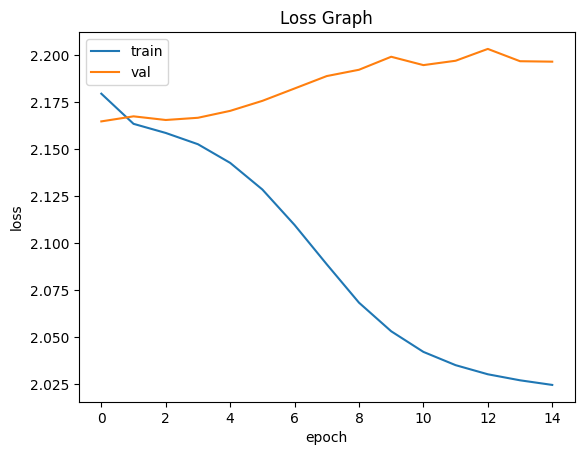

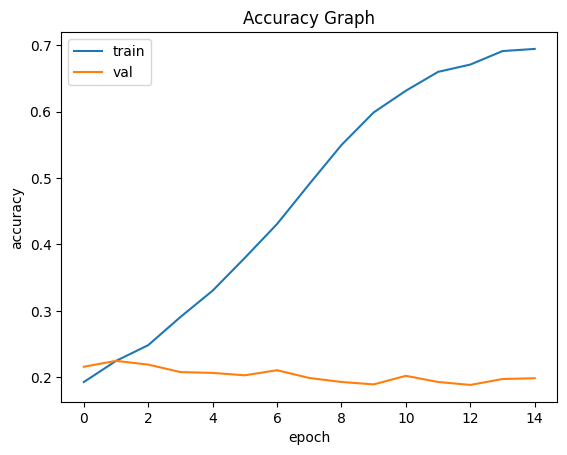

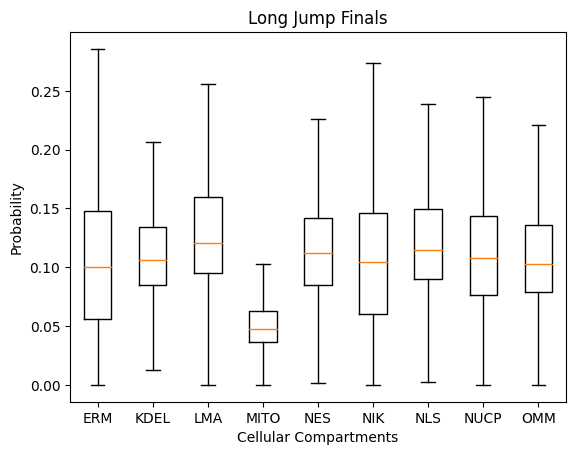

In [12]:
plt_data = [history.history['loss'], history.history['val_loss']]
plot_line_graph(plt_data, "Loss Graph", 'loss', 'epoch', ['train', 'val'])

plt_data = [history.history['accuracy'], history.history['val_accuracy']]
plot_line_graph(plt_data, "Accuracy Graph", 'accuracy', 'epoch', ['train', 'val'])

# scatter_plot(train_data, train_data)

box_plot(train_data)

In [ ]:
test_result = model.evaluate(test_data, **param_dataLoader_valid)
result = dict(zip(model.model.metrics_names, test_result))
TEST_ACCURACY = result['accuracy']
TEST_LOSS = result['loss']

In [ ]:
VALIDATION_ACCURACY

In [ ]:
VALIDATION_LOSS